In [61]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import optuna
import warnings
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

1. Regressor 모델을 Optuna, GridSearch 방식으로 예측.
2. CatBoost, RandomForest, XGB 사용.
3. R2 값 0.86 정도가 최대

In [35]:
df = pd.read_csv('/kaggle/input/insurance/insurance.csv')
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


### 전처리



In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


### EDA 프로세스

<span style = 'font-size: 18px;'>
나이, 성별, bmi, children, smoker, region에 따른 median charges 비용 차이를 시각화해보자


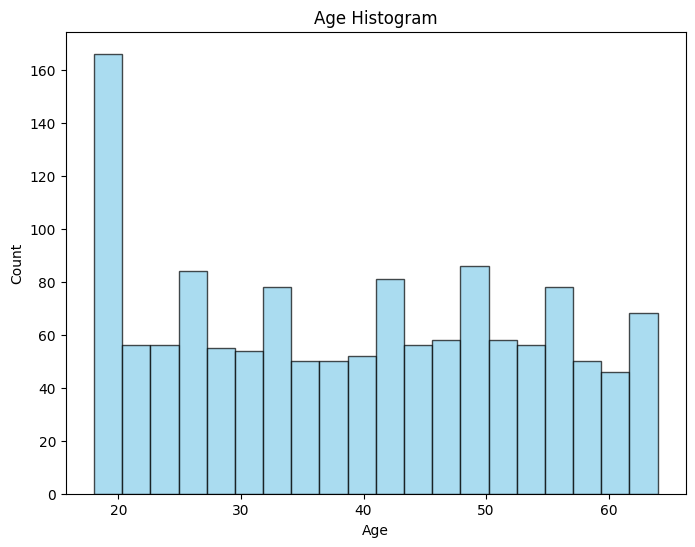

In [37]:
plt.figure(figsize = (8, 6))
plt.hist(df['age'], bins = 20, edgecolor = 'black', color = 'skyblue', alpha = 0.7)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age Histogram')
plt.show()

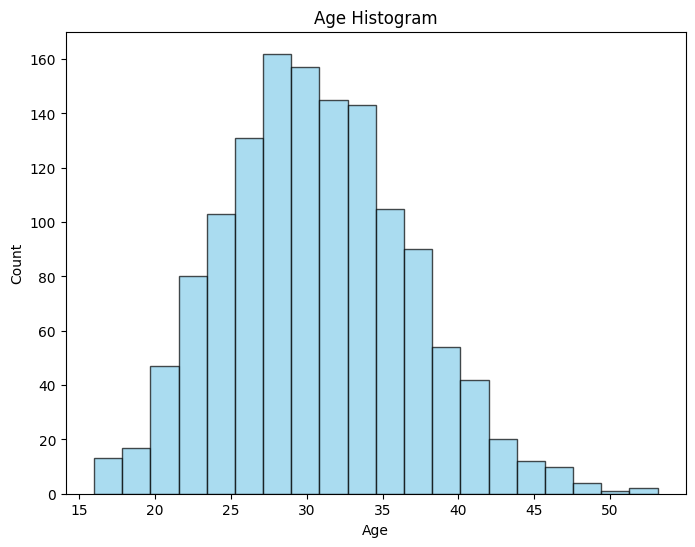

In [38]:
plt.figure(figsize = (8, 6))
plt.hist(df['bmi'], bins = 20, edgecolor = 'black', color = 'skyblue', alpha = 0.7)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age Histogram')
plt.show()

In [39]:
df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

In [40]:
age_bins = pd.qcut(df['age'], q=5)
age_labels = [f"{interval.left:.0f}-{interval.right:.0f}" for interval in age_bins.cat.categories]

bmi_bins = pd.qcut(df['bmi'], q=5)
bmi_labels = [f"{interval.left:.0f}-{interval.right:.0f}" for interval in bmi_bins.cat.categories]


df['age_group'] = pd.qcut(df['age'], q=5, labels=age_labels)
df['bmi_group'] = pd.qcut(df['bmi'], q=5, labels=bmi_labels)

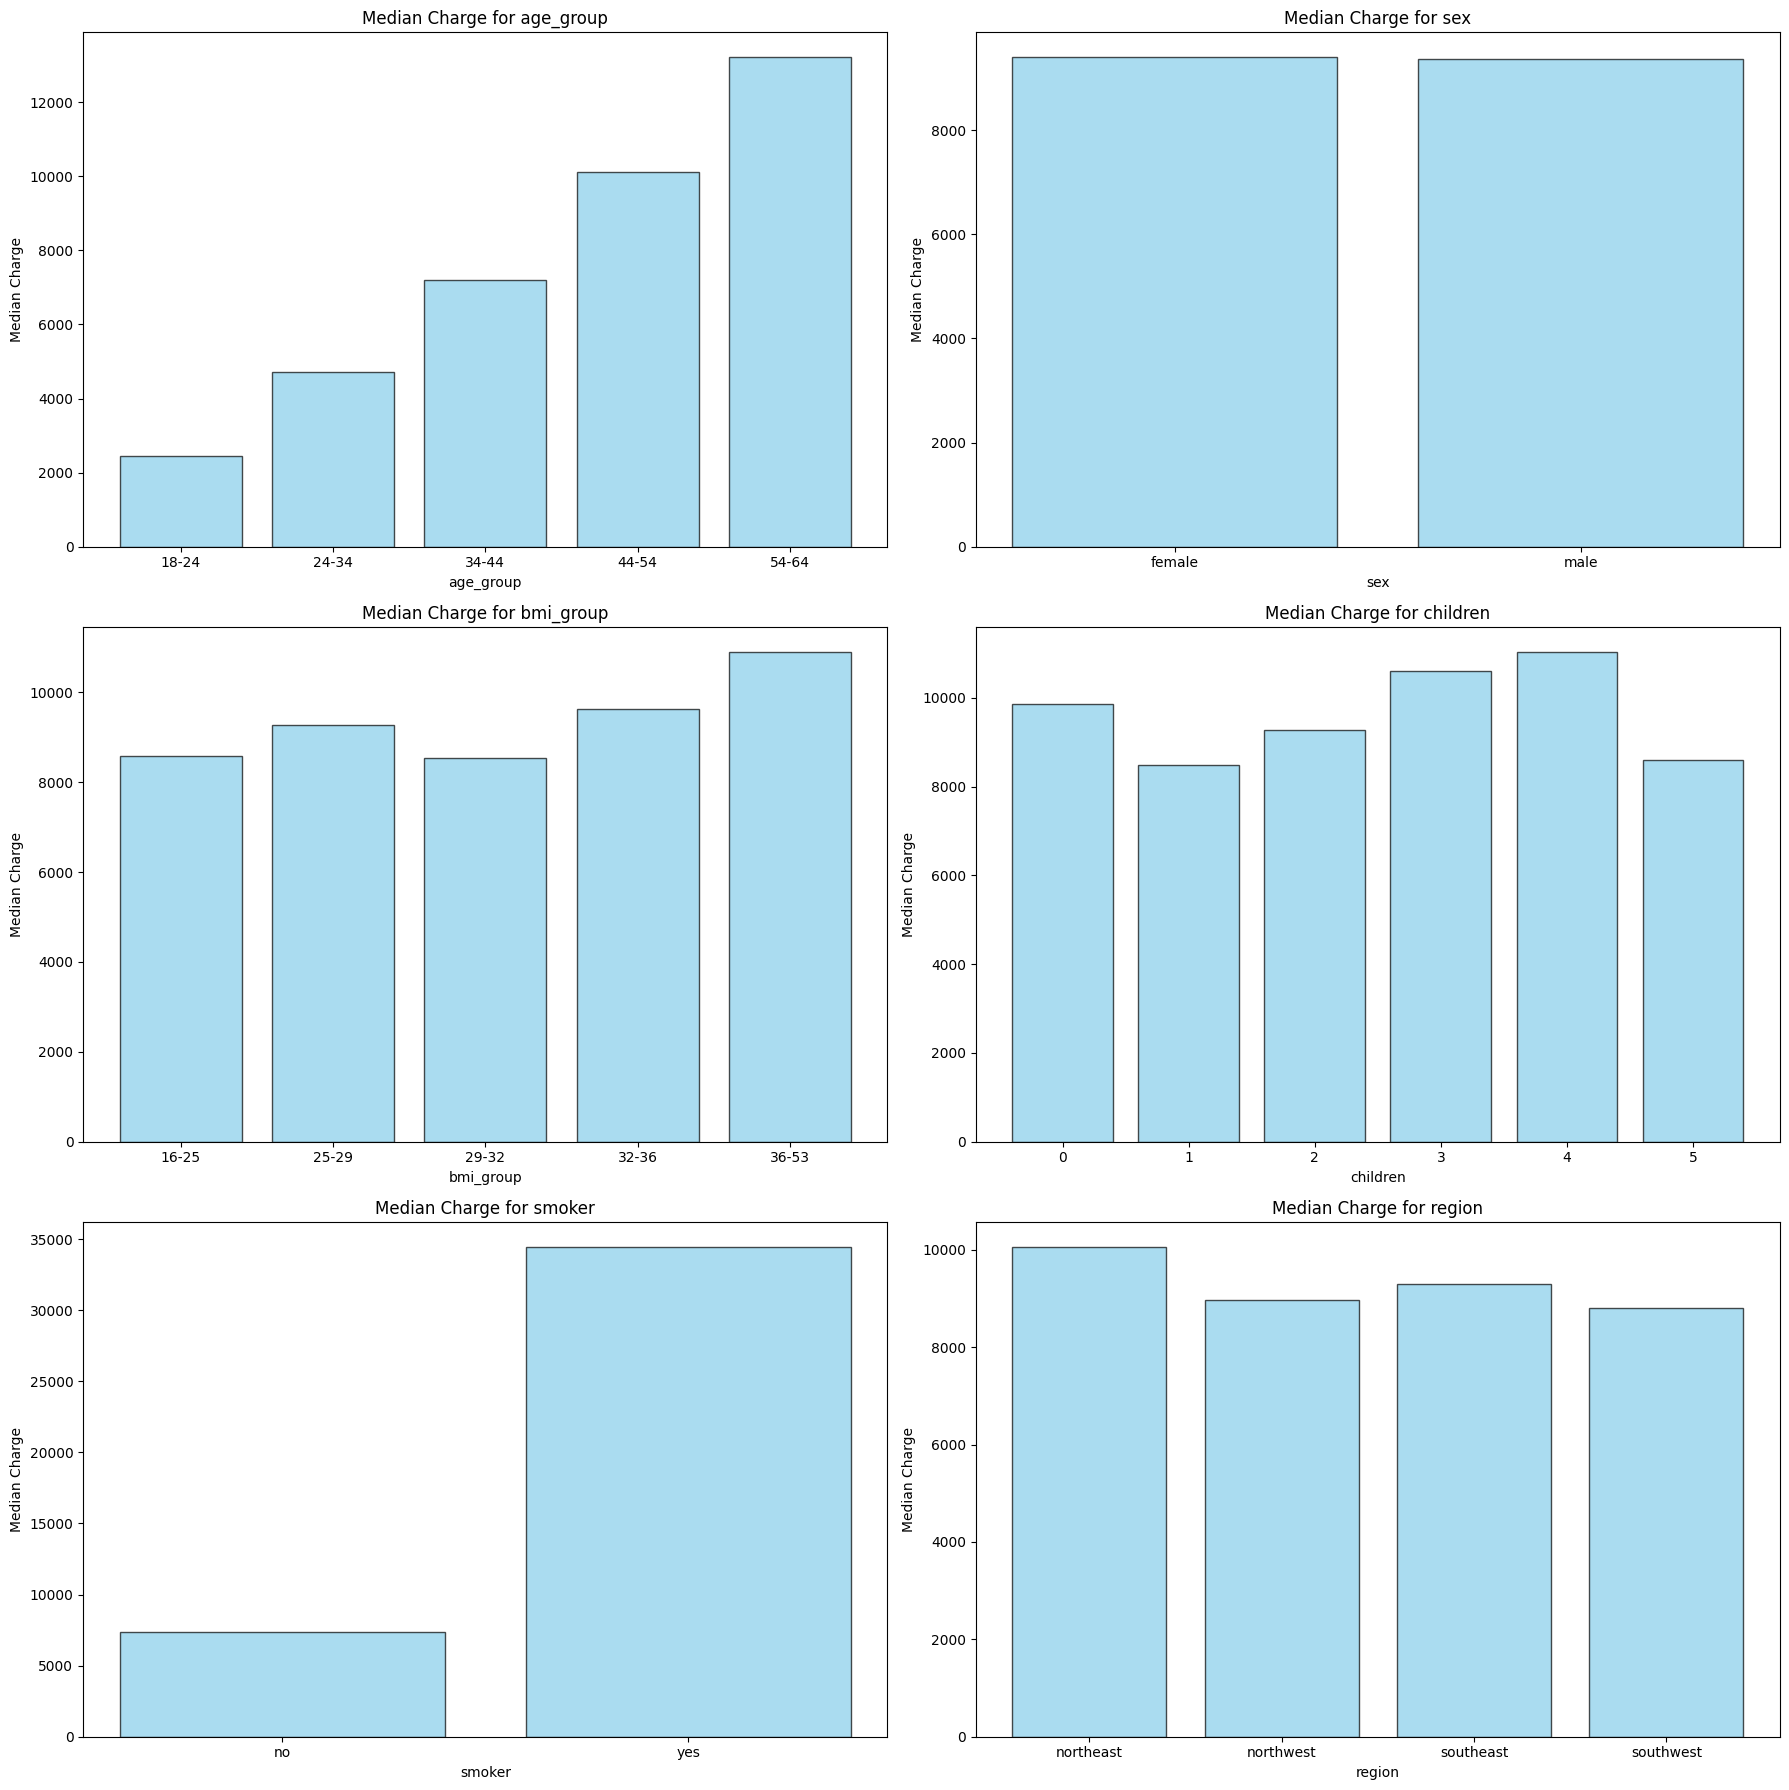

In [41]:
subset_df = df[['age_group', 'sex', 'bmi_group', 'children', 'smoker', 'region', 'charges']]

fig, axes = plt.subplots(3, 2, figsize = (18, 18))
axes = axes.flatten()

for i, col in enumerate(subset_df.columns):
    if i != 6:
        grouped_df = subset_df.groupby(by = col, observed = True)['charges'].median()
        axes[i].bar(grouped_df.index.astype(str), grouped_df.values, edgecolor= 'black', alpha = 0.7, color = 'skyblue')
        axes[i].set_title(f'Median Charge for {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Median Charge')

plt.tight_layout()
plt.show()

In [42]:
df.head(5)

,age,sex,bmi,children,smoker,region,charges,age_group,bmi_group
0,19,female,27.900,0,yes,southwest,16884.92400,18-24,25-29
1,18,male,33.770,1,no,southeast,1725.55230,18-24,32-36
2,28,male,33.000,3,no,southeast,4449.46200,24-34,32-36
3,33,male,22.705,0,no,northwest,21984.47061,24-34,16-25
4,32,male,28.880,0,no,northwest,3866.85520,24-34,29-32


In [43]:
df['bmi_group'].unique()

['25-29', '32-36', '16-25', '29-32', '36-53']
Categories (5, object): ['16-25' < '25-29' < '29-32' < '32-36' < '36-53']

In [44]:

processed_df = df.copy()
processed_df.drop(columns = ['age_group', 'bmi_group'], inplace = True)

'''
label_encoder = LabelEncoder()
ordinal_encoder = OrdinalEncoder()



ss_scaler = StandardScaler()
processed_df[['age', 'bmi']] = ss_scaler.fit_transform(processed_df[['age', 'bmi']])

'''

for col in ['sex','smoker']:
    processed_df[col] = label_encoder.fit_transform(df[col]) 
    
ohe = OneHotEncoder(sparse_output = False , drop = 'first')
encoded_region = ohe.fit_transform(df[['region']])
region_cols = [f"region_{i}"  for i in range(encoded_region.shape[1]) ]

encoded_df = pd.DataFrame(encoded_region, columns = region_cols, index = processed_df.index)

processed_df = pd.concat([processed_df, encoded_df], axis=1).drop(columns=['region'])


In [45]:
processed_df

,age,sex,bmi,children,smoker,charges,region_0,region_1,region_2
0,19,0,27.900,0,1,16884.92400,0.0,0.0,1.0
1,18,1,33.770,1,0,1725.55230,0.0,1.0,0.0
2,28,1,33.000,3,0,4449.46200,0.0,1.0,0.0
3,33,1,22.705,0,0,21984.47061,1.0,0.0,0.0
4,32,1,28.880,0,0,3866.85520,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
1333,50,1,30.970,3,0,10600.54830,1.0,0.0,0.0
1334,18,0,31.920,0,0,2205.98080,0.0,0.0,0.0
1335,18,0,36.850,0,0,1629.83350,0.0,1.0,0.0
1336,21,0,25.800,0,0,2007.94500,0.0,0.0,1.0


1. Children 그대로 냅두고, sex와 smoker, region 등은 이진변수. age와 sex는 정규화 적용.
2. 모든 변수 정규화

### 1. XGBoost

In [59]:



X = processed_df.drop(columns = 'charges')
y = processed_df['charges']
param_grid = {
    'n_estimators' : [175],
    'max_depth' : [2, 3],
    'learning_rate' : [0.01, 0.05],
    'gamma' : [1.8],
    'reg_lambda' : [0],
    'colsample_bytree' : [0.76]
    
}

xgbregressor = XGBRegressor()

gridsearch = GridSearchCV(estimator = xgbregressor, 
             param_grid =  param_grid,
             cv = 5,
             scoring = 'neg_mean_squared_error',
             n_jobs = -1,
             verbose = 1
            )

gridsearch.fit(X, y)
results_df = pd.DataFrame(gridsearch.cv_results_['params'])
results_df['mean_test_score'] = np.sqrt(gridsearch.cv_results_['mean_test_score'] * -1)
results_df.sort_values(by = 'mean_test_score', ascending = False, inplace = True)
display(results_df.head(5))


Fitting 5 folds for each of 4 candidates, totalling 20 fits


,colsample_bytree,gamma,learning_rate,max_depth,n_estimators,reg_lambda,mean_test_score
0,0.76,1.8,0.01,2,175,0,5819.051397
1,0.76,1.8,0.01,3,175,0,5685.387097
3,0.76,1.8,0.05,3,175,0,4531.074127
2,0.76,1.8,0.05,2,175,0,4501.859866


In [78]:

warnings.simplefilter(action = 'ignore',category = UserWarning)
optuna.logging.set_verbosity(optuna.logging.WARNING)

X = processed_df.drop(columns = 'charges')
y = processed_df['charges']

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 75, 250, step = 25)
    max_depth = trial.suggest_int('max_depth', 2,6, step = 1)
    learning_rate = trial.suggest_float('learning_rate', 1e-3, 0.1, log=True)
    gamma = trial.suggest_float('gamma', 1e-3, 3, log =True)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.6, 0.8, log=True)
    reg_lambda = trial.suggest_float('reg_lambda', 1e-3, 3, log =True )
    reg_alpha  =trial.suggest_float('reg_alpha', 1e-3, 3, log = True)

    
    model = XGBRegressor(
        n_estimators = n_estimators,
        max_depth = max_depth,
        learning_rate = learning_rate,
        gamma = gamma,
        colsample_bytree = colsample_bytree,
        reg_lambda = reg_lambda,
        n_jobs = -1
    )

    scores = cross_val_score(model, X, y, cv = 5, scoring = 'r2')
    mean_score = np.mean(scores)
    return mean_score

study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 50, show_progress_bar = False)


print("Best hyperparameters:", study.best_params)
print("Best score:", study.best_value)


Best hyperparameters: {'n_estimators': 150, 'max_depth': 2, 'learning_rate': 0.049094736850816646, 'gamma': 0.0016328378760870894, 'colsample_bytree': 0.7640510609771535, 'reg_lambda': 0.24944350135423407, 'reg_alpha': 1.6593821404225577}
Best score: 0.860551048723913


### 2. RandomForestRegressor

In [68]:
X = processed_df.drop(columns = 'charges')
y = processed_df['charges']



rf = RandomForestRegressor()
param_grid = {
    'n_estimators' : [200],
    'max_depth' : [6 , 7, 8],
    'min_samples_split' : [2],
    'min_samples_leaf' : [4],
    'max_features' : ['sqrt', 'log2', None],
    'bootstrap' : [True, False]
    
}

gridsearch = GridSearchCV(estimator = rf,
             param_grid = param_grid,
             verbose = 0,
             n_jobs = -1,             
             cv = 5)

gridsearch.fit(X, y )
rf_df = pd.DataFrame(gridsearch.cv_results_['params'])
rf_df['mean_test_score'] = gridsearch.cv_results_['mean_test_score']
rf_df.sort_values(by = 'mean_test_score', ascending = False, inplace = True)
display(rf_df.head(5))

,bootstrap,max_depth,max_features,min_samples_leaf,min_samples_split,n_estimators,mean_test_score
2,True,6,None,4,2,200,0.857515
5,True,7,None,4,2,200,0.855935
8,True,8,None,4,2,200,0.854281
16,False,8,log2,4,2,200,0.851933
13,False,7,log2,4,2,200,0.850505


In [71]:
warnings.simplefilter(action = 'ignore' ,category= UserWarning)
optuna.logging.set_verbosity(optuna.logging.WARNING)

X = processed_df.drop(columns = 'charges')
y = processed_df['charges']

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 500, step = 100)
    max_depth = trial.suggest_int('max_depth', 3, 8, step = 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 3, 12, step = 2)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 4, step = 1)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])
    

    model = RandomForestRegressor(
        n_estimators = n_estimators,
        max_depth = max_depth,
        min_samples_split = min_samples_split,
        min_samples_leaf = min_samples_leaf,
        max_features = max_features,
        bootstrap =bootstrap,
        n_jobs = -1,
        random_state = 4
    )
    
    scores = cross_val_score(model, X, y, cv = 5, scoring = 'r2')
    mean_score = np.mean(scores)
    return mean_score

study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 50, show_progress_bar = False)


print("Best hyperparameters:", study.best_params)
print("Best score:", study.best_value)

Best hyperparameters: {'n_estimators': 500, 'max_depth': 5, 'min_samples_leaf': 9, 'min_samples_split': 3, 'max_features': None, 'bootstrap': True}
Best score: 0.860502069965421


#### 3. CatBoost

In [74]:



def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 500, step=100)
    max_depth = trial.suggest_int('max_depth', 3, 8, step=1)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
    l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 1e-3, 10, log=True)
    bootstrap_type = trial.suggest_categorical('bootstrap_type', ['Bayesian', 'MVS'])
    grow_policy = trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide'])

    
    model = CatBoostRegressor(
        iterations=n_estimators,
        depth=max_depth,
        learning_rate=learning_rate,
        l2_leaf_reg=l2_leaf_reg,
        bootstrap_type=bootstrap_type,
        grow_policy=grow_policy,
        random_seed=42,
        verbose=0
    )
    
    scores = cross_val_score(model, X, y, cv=5, scoring='r2')
    mean_score = np.mean(scores)
    return mean_score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, show_progress_bar=False)

print("Best hyperparameters:", study.best_params)
print("Best score:", study.best_value)


Best hyperparameters: {'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.021248575707491207, 'l2_leaf_reg': 0.04875020061813086, 'bootstrap_type': 'Bayesian', 'grow_policy': 'SymmetricTree'}
Best score: 0.8605420993269902
